In [3]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp
import cmocean
#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray 		import *
from sub_fesom_mesh 		import * 
from sub_fesom_data 		import * 
from sub_fesom_plot 		import *
from sub_fesom_selectline	import *
from sub_regriding_adapt	import *
from colormap_c2c			import *
from sub_climatology        import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#+_____________________________________________________________________________+
#|                         *** LOAD FVSOM MESH ***                             |
#+_____________________________________________________________________________+
inputarray  = set_inputarray()
inputarray['save_fig'] = False
#inputarray['save_fig'] = True
inputarray['save_figpath'] = '/scratch/users/pscholz/AWI_PAPER/PAPER_FESOM2.0_evaluation/figures/withoutPC-2/zlevel-linfs/lines/'

# inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2', '/work/ollie/pscholz/mesh_fesom2.0/mesh_CORE2_finaltopo_mean/'
inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/core2_meanz/'
try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   

 --> ___FOUND COREv2 FESOM MESH --> will use it!___________________________


In [6]:
#+_____________________________________________________________________________+
# predefine section lines or leave it empty in this case interactive selection 
line				= fesom_line()
# line.line_define    =  list([[]]) # --> more line ,  list([[],[],...,...]) 
# line.line_define[0] = [[-72.5, -64.625,-58.5], [43.781, 32.469, 28.5], 'GS']
line.line_define    =  list([[]]) # --> more line ,  list([[],[],...,...]) 
line.line_define[0] = [[-30.0, -30.0], [-80.0, 40.0], 'atlantic']
# line.line_define[0] = [[-170.0, -170.0], [-80.0,65.0], 'test_pacific']
line.line_define[0] = [[-30.0, -30.0], [-80.0, 90.0], 'atlantic']

#+_____________________________________________________________________________+
# line.descript,line.path = 'zstar' , '../results/'+'zstar'+'_pgf/'+'/withoutPC-3/'
# line.descript,line.path = 'linfs-kpp' , '../results/linfs/kpp/2/'
# line.descript,line.path = 'linfs-dima' , '/work/ollie/dsidoren/results/CORE2/fesom2_paper/gm_redi_11/2/'
line.descript,line.path = '[cvmix_TKE_ubndcF_cd=3.75]' ,'../results/new_linfs/cvmix_tke_cd3.75/3/'
line.var 	= 'Kv'  # 
#line.var 	= 'vec_uv'  # --> volume flux
#line.var 	= 'vec_tuv' # --> heat flux
#line.var 	= 'vec_suv' # --> liquid freshwater flux (not tested yet)
#line.var 	= '.....'   # --> all other 3d fesom2.0 variable (temp, salt, u,v,w,...)
#+_____________________________________________________________________________+
# select year to average over [start_yr, end_yr]
line.year	= [1989,2009]

# select month to average over
line.month	= list(range(1,12+1))

# select linear interpolated depth layers to average over, empty mean use all layers
# don't touch here, should be empty !
line.depth	= []

#+_____________________________________________________________________________+
# make anomaly
do_anomaly      = True
# do_anomaly      = False
if do_anomaly==True:
    line2 			= cp.copy(line) # init fesom2.0 data object
    #line2.descript,line2.path = 'zlevel','/media/pscholz/data_ext_2/DATA_FESOM2.0/zlevel/withoutPC-2/'
    #line2.descript,line.path = 'linfs' , '../results/linfs/kpp/3/'
    line2.descript,line2.path = '[cvmix_TKE_ubndcF_cd=1.0]'       ,'../results/new_linfs/cvmix_tke/3/'


In [7]:
# +_____________________________________________________________________________+
# |                    *** LINE SELECTION PROCESS ***                           |
# +_____________________________________________________________________________+
# --> interactive figure line selection 
# 		[left mouse]  ... preselect area, move window
# 		[right mouse] ... zoom out completly
# 		button [+] ... zoom in
# 		button [-] ... zoom out
# 		button [L] ... first time push [l] - start line selection, line points can 
# 					   now be selected with left mouse button, second time push of [L]
# 					   finishes selection of a single line. If this is repeated 
# 					   several lines can be selected
# 		button [d] ... delete point that was just selected
# 		button [q] ... finshes entire selection process, goes on with the calculation 
# 					   of the cross-section
	   
# you need to close window to proceed

#  !!! DOES NOT FULLY WORK YET WITH JUPYTHER NOTBOOK ONLY WITH IPYTHON2 COMMAND LINE !!!

# if len(line.line_define)==0:
# 	#___________________________________________________________________________
# 	fig, ax = plt.figure(figsize=(13, 13)), plt.gca()
# 	map 	= Basemap(projection = 'cyl',resolution = 'c',
# 				llcrnrlon = -180, urcrnrlon = 180, llcrnrlat = -90, urcrnrlat = 90)
# 	mx,my 	= map(mesh.nodes_2d_xg, mesh.nodes_2d_yg)
	
# 	#___________________________________________________________________________
# 	tri     = Triangulation(mx, my,mesh.elem_2d_i)
# 	hp1		= plt.tripcolor(tri,-mesh.nodes_2d_z,cmap=cmocean.cm.deep)
# 	#hp1		=plt.tripcolor(tri,data_anom.value,cmap=cmocean.cm.balance)
# 	#plt.clim(-0.50,0.50)
	
# 	#___________________________________________________________________________
# 	map.drawmapboundary(fill_color='0.9',linewidth=1.0)
# 	# map.bluemarble(scale=0.25)
# 	# map.etopo()
# 	#fesom_plot_lmask(map,mesh,ax,'none','r')
# 	ax.grid(color='k', linestyle='-', linewidth=0.5)
# 	plt.xscale('linear')
# 	plt.yscale('linear')
# 	plt.show(block=False)
# 	fig.canvas.draw()
	
# 	#___________________________________________________________________________
# 	# interactively
# 	line._cid_pressb = fig.canvas.mpl_connect('button_press_event', line._anybutton_)
# 	line._cid_pressk = fig.canvas.mpl_connect('key_press_event', line._anykey_)
# 	line._connect_(fig,ax,map)

In [8]:
#+_____________________________________________________________________________+
# analyse selected lines, calculate interpolation points
print(' --> calculate interpolation points')
# which   ... res/npoints
# res     ... interpolation resolution in deg
# npoints ... use npoints per line segment for interpolation
line.analyse_lines(which='res',res=0.1)
#line.analyse_lines(which='res',res=1.0)
if do_anomaly==True:
	line2.line_define = line.line_define
	line2.analyse_lines(which='res',res=0.1) 

#+_____________________________________________________________________________+
#|                            *** LOAD 3D DATA ***                             |
#+_____________________________________________________________________________+
# load 3d fesom2.0 data on original depth layers --> line.value
print(' --> load 3d fesom2.0 data')
fesom_load_data_horiz(mesh,line)
if do_anomaly==True:
	fesom_load_data_horiz(mesh,line2)
#+_____________________________________________________________________________+
#|                *** INTERPOLATE 3D DATA ON LINESEGMENT ***                   |
#+_____________________________________________________________________________+
# interpolate points on fesom2.0 data, use routine of Nikolay fesom2regular(...)
print(' --> do interpolation on data')
if do_anomaly==False:
	line.interp_lines(mesh)
	if line.var.find('vec')!=-1: line.calc_flux()
else:
	if line.var.find('vec')!=-1:
		# calculate data on line and line2 data
		line.interp_lines(mesh)
		line2.interp_lines(mesh)		
		# calculate flux through line and line2
		line.calc_flux()
		line2.calc_flux()		
		# calculate anomaly line2-line ... 
		anom = cp.copy(line)
		anom.data_anom(line,line2)
	else:
		line.interp_lines(mesh)
		line2.interp_lines(mesh)		
		anom = cp.copy(line)
		anom.data_anom(line,line2)

 --> calculate interpolation points
 --> load 3d fesom2.0 data

     -----+-----------------------------------+------------
     Year |               MON                 |
     -----+-----------------------------------+------------
     --> ../results/new_linfs/cvmix_tke_cd3.75/3/
     --> Kv
     1989 |annual | --> t=0.10s
     1990 |annual | --> t=0.05s
     1991 |annual | --> t=0.05s
     1992 |annual | --> t=0.07s
     1993 |annual | --> t=0.07s
     1994 |annual | --> t=0.07s
     1995 |annual | --> t=0.09s
     1996 |annual | --> t=0.07s
     1997 |annual | --> t=0.05s
     1998 |annual | --> t=0.06s
     1999 |annual | --> t=0.05s
     2000 |annual | --> t=0.06s
     2001 |annual | --> t=0.06s
     2002 |annual | --> t=0.07s
     2003 |annual | --> t=0.05s
     2004 |annual | --> t=0.08s
     2005 |annual | --> t=0.06s
     2006 |annual | --> t=0.07s
     2007 |annual | --> t=0.05s
     2008 |annual | --> t=0.07s
     2009 |annual | --> t=0.05s

     -----+----------------------

 --> plot line data


<IPython.core.display.Javascript object>


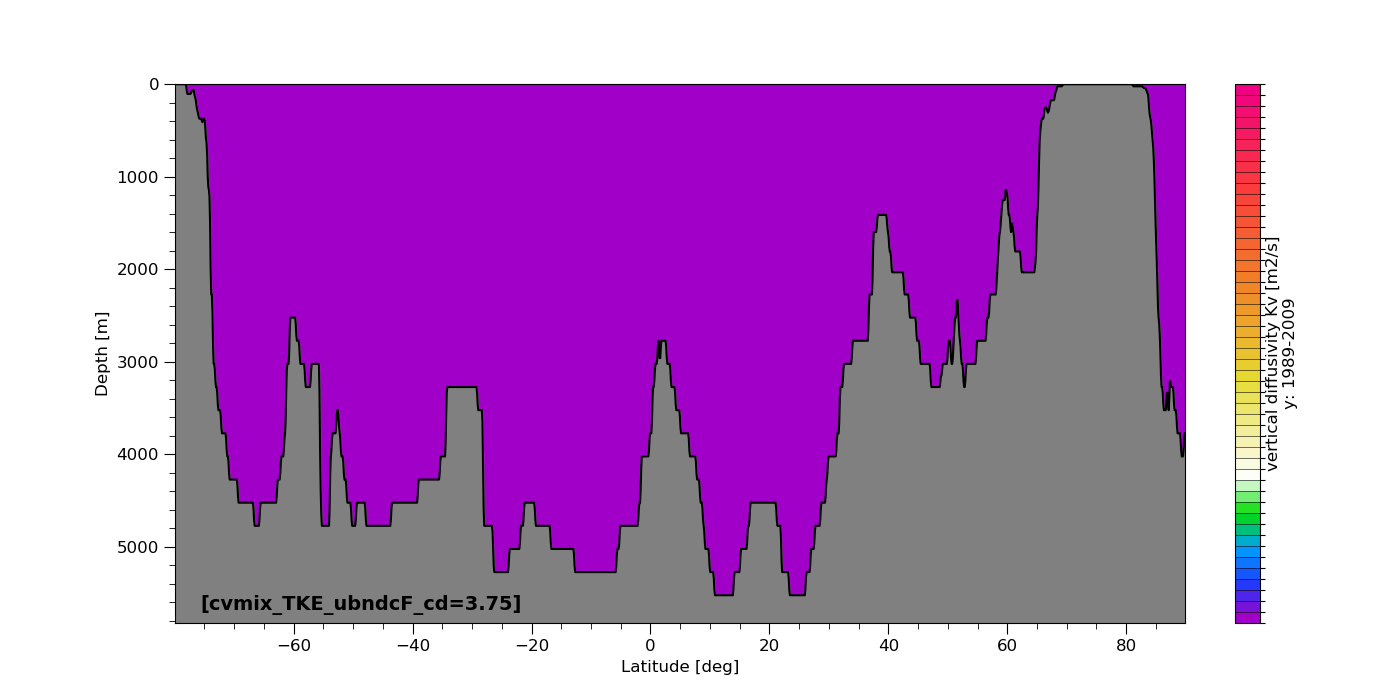

/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_selectline.py:967: RuntimeWarning: invalid value encountered in less
  data_plot[data_plot<clevel[0]]  = clevel[0]+np.finfo(np.float32).eps
/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_selectline.py:968: RuntimeWarning: invalid value encountered in greater
  data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps
/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_selectline.py:1020: UserWarning: No contour levels were found within the data range.
  vmin=clevel[0], vmax=clevel[-1])
/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_selectline.py:1027: UserWarning: No contour levels were found within the data range.
  vmin=clevel[0], vmax=clevel[-1])
/home/ollie/pscholz/fesom2.0_git/view_pscholz/sub_fesom_selectline.py:1034: UserWarning: No contour levels were found within the data range.
  vmin=clevel[0], vmax=clevel[-1])


<IPython.core.display.Javascript object>


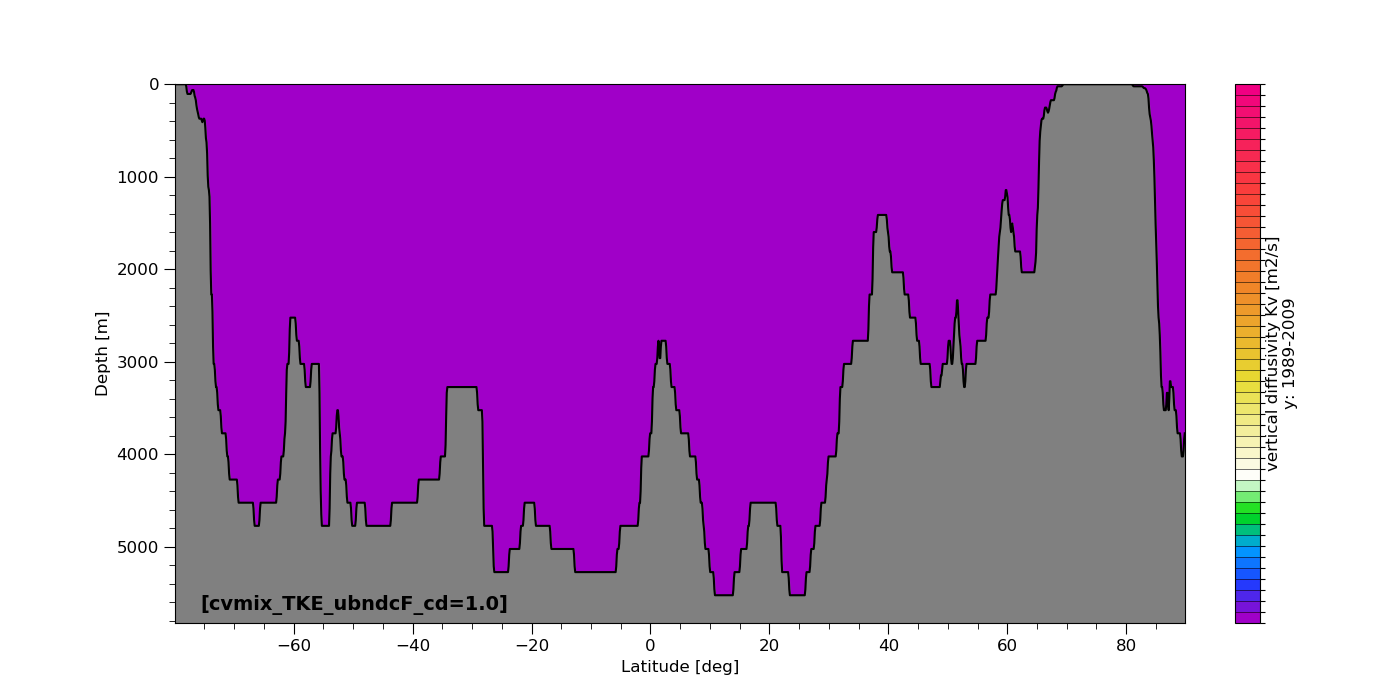

<IPython.core.display.Javascript object>


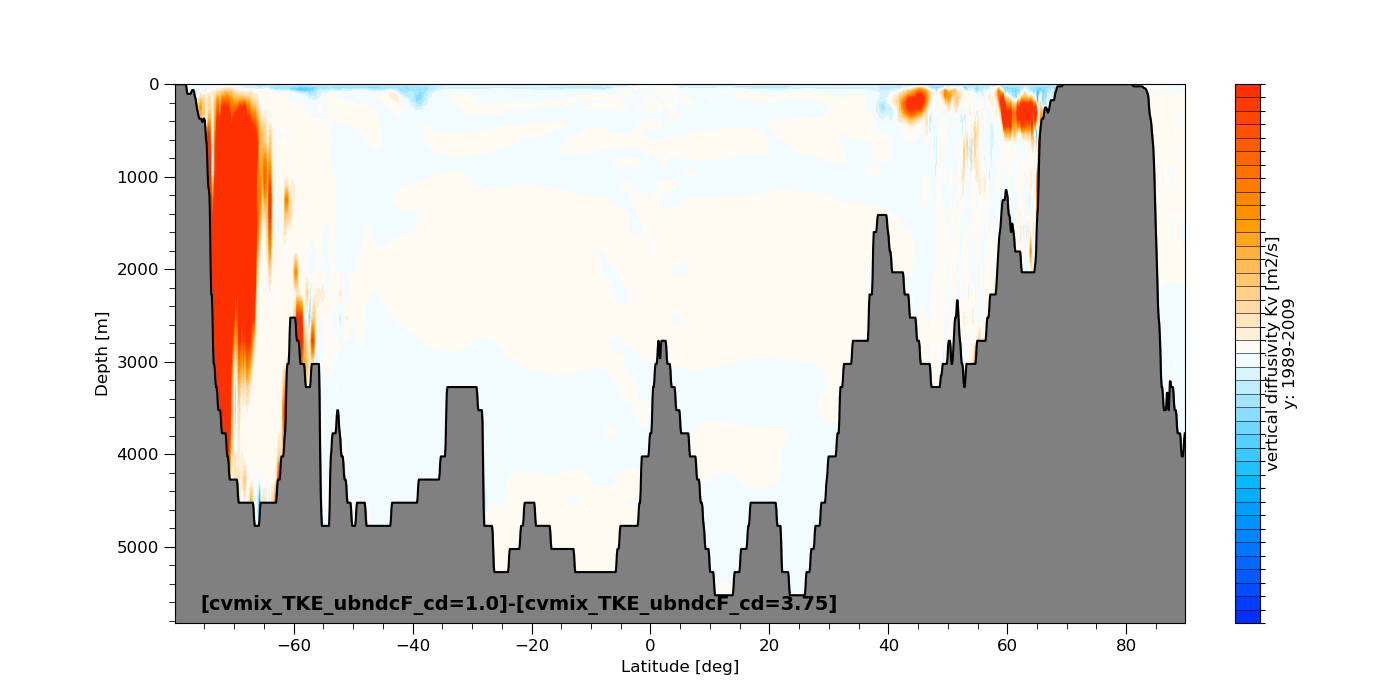

In [9]:
#+_____________________________________________________________________________+
#|                        *** PLOT LINE OVER DEPTH ***                         |
#+_____________________________________________________________________________+
print(' --> plot line data')
# line.plot_lines_position(mesh)




if  do_anomaly==True and line.var.find('vec')!=-1:
    #___________________________________________________________________________
    # do common crange for line and lin2
    cmax = np.max([np.nanmax(line.value[0]),np.nanmax(line2.value[0])])
    cmin = np.min([np.nanmin(line.value[0]),np.nanmin(line2.value[0])])
    cref = cmin + (cmax-cmin)/2
    cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
    line.crange=[cmin,cmax,cref]	
    line2.crange=[cmin,cmax,cref]
    line.crange,line.cnumb,line.cmap=[34.1,36.0,34.6],20,'blue2red'
    anom.crange,anom.cnumb,anom.cmap=[34.1,36.0,34.6],20,'blue2red'
    #___________________________________________________________________________
    line.plot_lines_dist_x_z(figsize=[16,11])
    line2.plot_lines_dist_x_z(figsize=[16,11])
    anom.plot_lines_dist_x_z(figsize=[16,11])
else:
    if do_anomaly==True:
        #_______________________________________________________________________
        # do common crange for line and lin2
        cmax = np.max([np.nanmax(line.value[0]),np.nanmax(line2.value[0])])
        cmin = np.min([np.nanmin(line.value[0]),np.nanmin(line2.value[0])])
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        line.crange=[cmin,cmax,cref]	
        line2.crange=[cmin,cmax,cref]
#         line.crange,line.cnumb,line.cmap=[34.1, 36.5, 34.7],40,'grads'
#         line2.crange,line2.cnumb,line2.cmap=[34.1, 36.5, 34.7],40,'grads'
        anom.crange,anom.cnumb,anom.cmap=[-0.01,0.01,0.0],40,'blue2red'
        #_______________________________________________________________________
        line.plot_lines_dist_x_z(figsize=[14,7],which_lines=[1,1,1])
        line2.plot_lines_dist_x_z(figsize=[14,7],which_lines=[1,1,1])
        anom.plot_lines_dist_x_z(figsize=[14,7],which_lines=[0,0,0])
    else:
        line.crange,line.cnumb,line.cmap=[34.1, 36.5, 34.7],40,'grads'
#         line.crange,line.cnumb,line.cmap=[26.0,27.8,27.4],20,'grads'
        line.plot_lines_dist_x_z(figsize=[14,7],which_lines=[1,1,0])


In [ ]:


#+_____________________________________________________________________________+
which_clim ='woa05' #'woa05','phc3'
linec = cp.deepcopy(line)
if which_clim=='phc3': 
    linec.path, linec.fname = '../view/phc3/', 'phc3.0_annual.nc'
elif which_clim=='woa05': 
    linec.path, linec.fname = '../view/woa2005/', 'woa2005TS.nc'
linec = clim_load_data(linec)
linec.interp_lines_reg()

#+_____________________________________________________________________________+
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[12,12])
line.crange,line.cnumb,line.cmap=[34.1, 36.5, 34.7],35,'grads'
line.plot_lines_dist_x_z(do_subplot=[fig,ax1],which_lines=[1,1,0])

linec.crange,linec.cnumb,linec.cmap=[34.1, 36.5, 34.7],35,'grads'
linec.plot_lines_dist_x_z(do_subplot=[fig,ax2],which_lines=[1,1,0])